# PyVBMC Example 6: Noisy log-likelihood evaluations

In this notebook, we demonstrate running PyVBMC with noisy evaluations of the log-likelihood. Here we emulate a noisy scenario by adding random Gaussian noise to the log-likelihood. In practice, noisy evaluations often emerge from estimation techniques for simulation-based models, such as [Inverse Binomial Sampling (IBS)](https://github.com/acerbilab/ibs). However the noise estimate is obtained, it is allowed to be (and in practice, often is) _heteroskedastic_: that is, the amount of noise in the estimate may vary across parameter space.

This notebook is Part 5 of a series of notebooks in which we present various example usages for VBMC with the PyVBMC package. The code used in this example is available as a script [here](https://github.com/acerbilab/pyvbmc/blob/main/examples/scripts/pyvbmc_example_5_full_code.py).

In [1]:
import numpy as np
import scipy.stats as scs
from pyvbmc import VBMC
import dill
import matplotlib.pyplot as plt

## 1. Model definition: log-prior, noisy log-likelihood and log-joint

We use the same toy target function as in Example 1, a broad [Rosenbrock's banana function](https://en.wikipedia.org/wiki/Rosenbrock_function) in $D = 2$. But this time, we add random heteroskedastic Gaussian noise to the function evaluations.

In [2]:
D = 2  # We'll use a 2-D problem, again for speed
prior_mu = np.zeros(D)
prior_var = 3 * np.ones(D)
LB = np.full((1, D), -np.inf)  # Lower bounds
UB = np.full((1, D), np.inf)  # Upper bounds
PLB = np.full((1, D), prior_mu - np.sqrt(prior_var))  # Plausible lower bounds
PUB = np.full((1, D), prior_mu + np.sqrt(prior_var))  # Plausible upper


def log_prior(theta):
    """Multivariate normal prior on theta, same as before."""
    cov = np.diag(prior_var)
    return scs.multivariate_normal(prior_mu, cov).logpdf(theta)

The setup and prior function remain unchanged. For the likelihood, we'll take the Rosenbrock function and add some simulated noise to it. The noise here is arbitrary, but notice that the amount depends on the parameters $\theta$, with more noise when $\theta$ is farther from the origin: It is typical to have noisier estimates in lower-density regions of the posterior.

In the noisy-likelihood setting, the log-joint (or log-likelihood, if the prior is passed to PyVBMC separately) should return a pair of values: the noisy log-density as the first, and an estimate of the standard deviation of the noise as the second.

In [3]:
# log-likelihood (Rosenbrock)
def log_likelihood(theta):
    """D-dimensional Rosenbrock's banana function."""
    theta = np.atleast_2d(theta)
    n, D = theta.shape

    # Standard deviation of synthetic noise:
    noise_sd = np.sqrt(1.0 + 0.5 * np.linalg.norm(theta) ** 2)

    # Rosenbrock likelihood:
    x, y = theta[:, :-1], theta[:, 1:]
    base_density = -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)

    noisy_estimate = base_density + noise_sd * np.random.normal(size=(n, 1))
    return noisy_estimate, noise_sd

Since the log-likelihood function now has two outputs, we cannot directly sum the log-prior and log-likelihood. So our log-joint function looks slightly different. If you choose to pass the log-likelihood and log-prior separately, PyVBMC will handle this part for you.

In [4]:
# Full model:
def log_joint(theta, data=np.ones(D)):
    """log-density of the joint distribution."""
    log_p = log_prior(theta)
    log_l, noise_est = log_likelihood(theta)
    # For the joint, we have to add log densities and carry-through the noise estimate.
    return log_p + log_l, noise_est


x0 = np.zeros((1, D))  # Initial point

We omit optimizing `x0` to find a good starting point, as previously suggested, because naive optimization would fail badly for a noisy objective anyway. For noisy optimization, consider using [BADS](https://github.com/acerbilab/bads) or its Python port PyBADS --- coming soon!

## 2. Setting up a noisy `VBMC` instance

As a final step, we have to tell PyVBMC that we are working with a noisy likelihood, by turning on the `specify_target_noise` option. Otherwise PyVBMC will throw an `InvalidFuncValue` error, indicating that the target function is returning unexpected values.

In [5]:
options = {"specify_target_noise": True}
vbmc = VBMC(
    log_joint,
    x0,
    LB,
    UB,
    PLB,
    PUB,
    options=options,
)

In [6]:
np.random.seed(42)
vp, results = vbmc.optimize()

Beginning variational optimization assuming NOISY observations of the log-joint
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -1.28         0.75    230442.67        2        inf     start warm-up
     1         15          -1.74         0.44         0.04        2        inf     
     2         20          -2.85         0.56         2.77        2       66.6     
     3         25          -3.00         0.44         0.14        2        3.8     
     4         30          -2.80         0.38         0.27        2       6.74     end warm-up
     5         35          -2.94         0.33         0.34        2       8.44     
     6         40          -2.54         0.28         0.14        2       4.01     
     7         45          -2.54         0.25         0.02        3      0.814     
     8         50          -2.29         0.24         0.05        6       1.55     
     9         50          -1.90         1.02     

PyVBMC found a solution, even in the presence of noise. Let's compare to the variational posterior we found in the previous notebook, for the noise-free version of the same problem.

In [7]:
with open("noise_free_vp.pkl", "rb") as f:
    noise_free_vp = dill.load(f)
# KL divergence between this VP and the noise-free VP:
print(vbmc.vp.kl_div(vp2=noise_free_vp))

[0.05989518 0.08126687]


The KL divergence in both directions is small, and the ELBO is close to what we obtained before. We can also compare the densities visually and see that they are quite similar despite the noisy target:

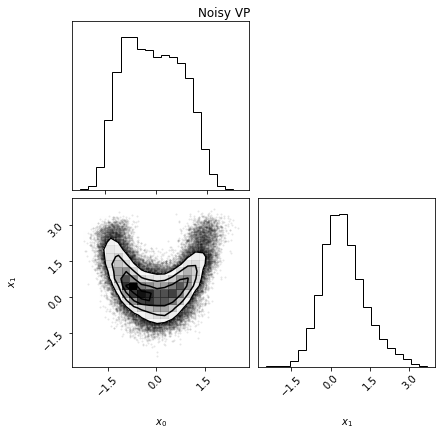

In [8]:
vp.plot(title="Noisy VP");

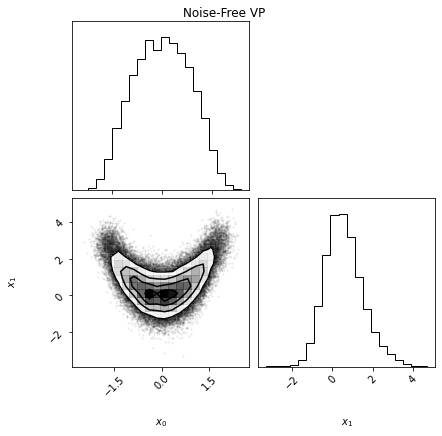

In [9]:
noise_free_vp.plot(title="Noise-Free VP");

## 3. Conclusions

In this notebook, we have illustrated how to use PyVBMC on a model with a noisy likelihood. Even in the presence of significant noise, PyVBMC can find a good variational solution in relatively few function evaluations.

## Acknowledgments

Work on the PyVBMC package was funded by the [Finnish Center for Artificial Intelligence FCAI](https://fcai.fi/).